## Using Hugging Face's Diffuser pipeline 🤗 
* for CIFAR-10 `unconditional` data generation
* used U-net model

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_scheduler
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

2025-07-24 10:14:20.315815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753352060.491552      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753352060.542292      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Create diffusion model for CIFAR-10 dataset
## Use U-net architecture in reverse diffusion
## Will use huggingface "Diffuser" library for
## now, for unconditional generation

def diffusion_train():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])
    
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

    ## Define U-net model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet2DModel(
        sample_size=32,
        in_channels=3,
        out_channels=3,
        layers_per_block=2,
        block_out_channels=(128, 256, 512, 512),
        norm_num_groups=32,
    )
    model.to(device)
    noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)
    num_epochs = 70

    for epoch in range(num_epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for images, _ in pbar:
            images = images.to(device)
            noise = torch.randn_like(images)
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (images.shape[0],), device=device).long()
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix({"loss": loss.item()})

    ## Generate samples
    pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
    pipeline.to(device)
    samples = pipeline(batch_size=64, generator=torch.manual_seed(0)).images
    return samples

`test samples`

In [3]:
samples = diffusion_train()

100%|██████████| 170M/170M [00:12<00:00, 14.1MB/s] 
Epoch 1/70:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 70/70: 100%|██████████| 782/782 [06:30<00:00,  2.00it/s, loss=0.0192]


  0%|          | 0/1000 [00:00<?, ?it/s]

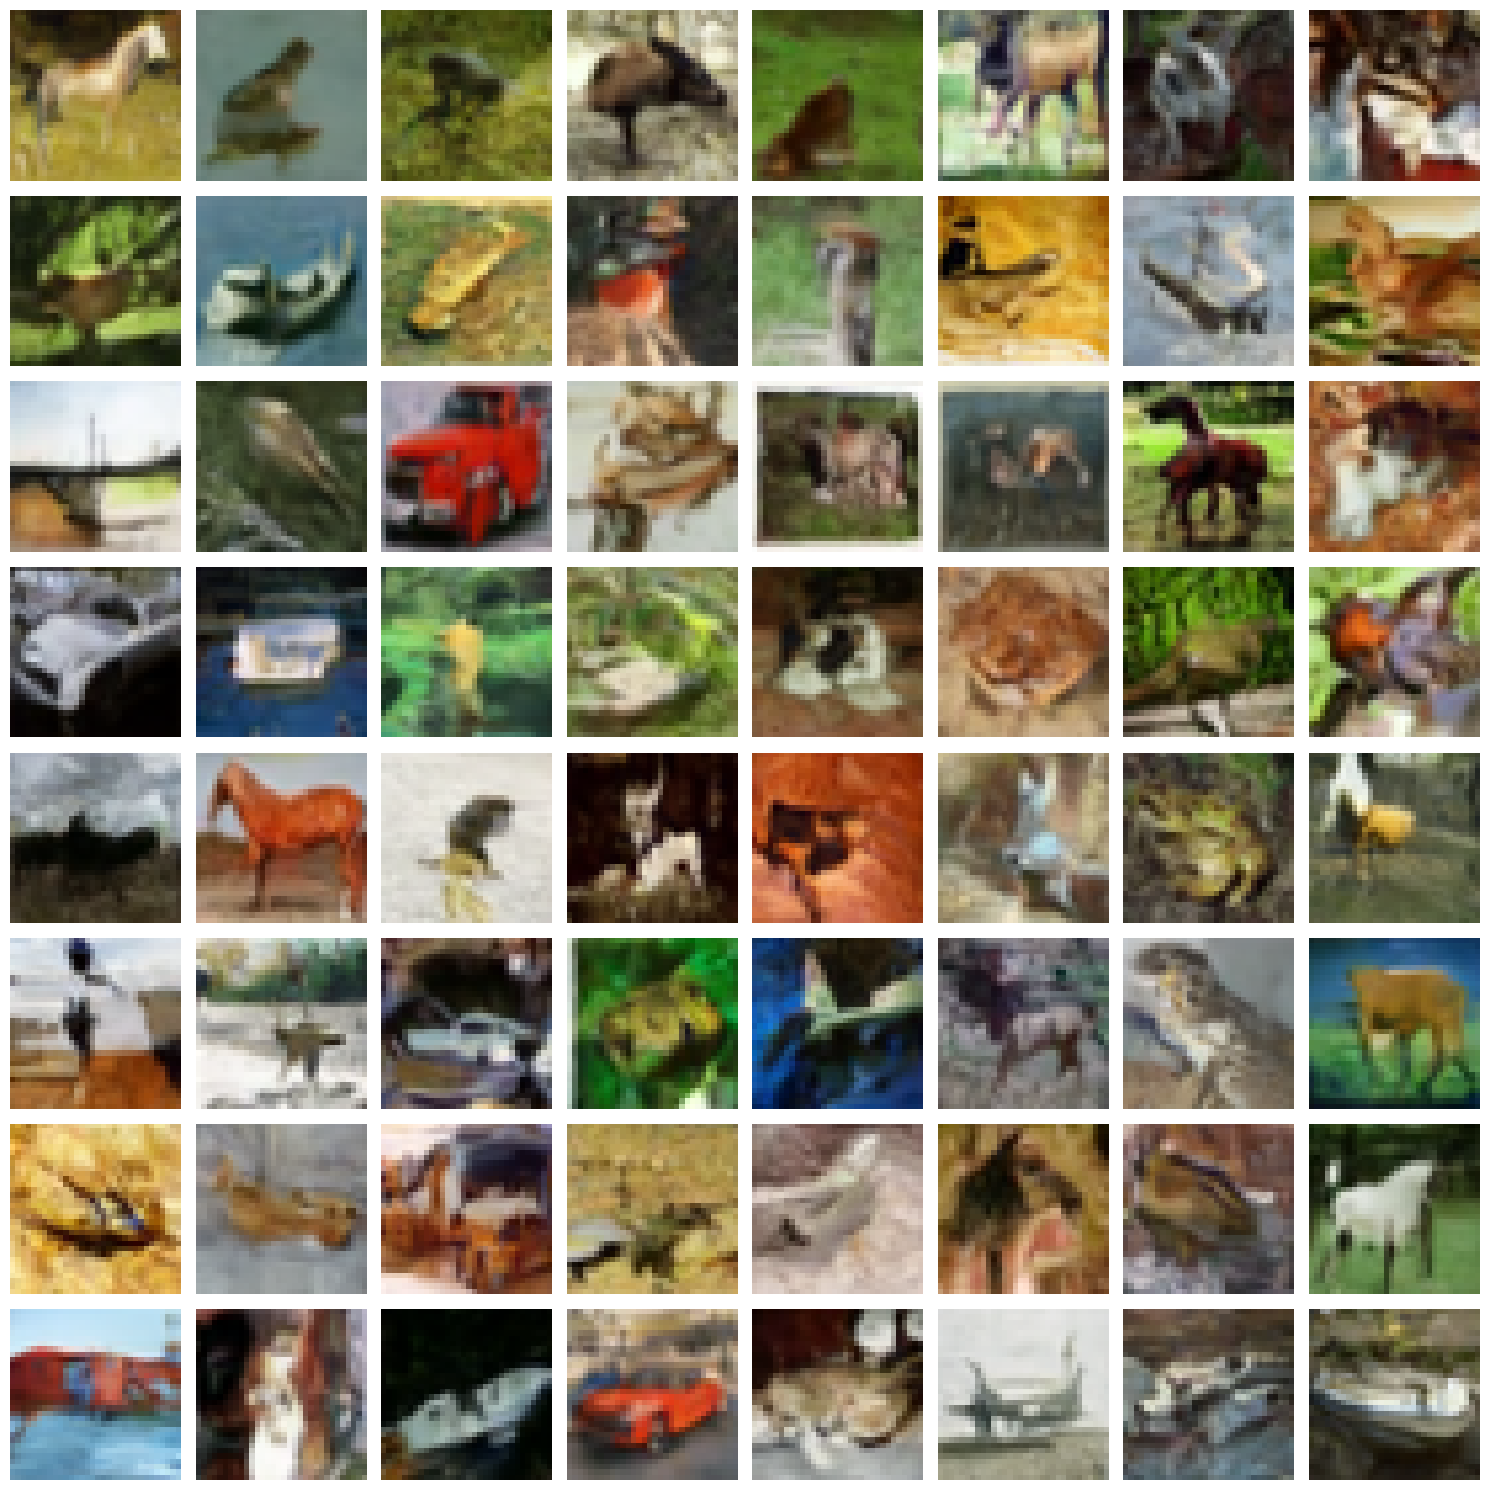

In [4]:
fig, axes = plt.subplots(8,8,figsize=(15,15))
for i, img in enumerate(samples):
    axes[i//8,i%8].imshow(img)
    axes[i//8,i%8].axis('off')
plt.tight_layout()
plt.show()

`Unconditional generation^^`

---